In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib

In [15]:
import os
import logging
import argparse
import glob
import json
from collections import Counter

import numpy as np
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses, concentration_utils 
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot import label_metadata
from zoobot.active_learning import acquisition_utils
from zoobot.estimators import dirichlet_stats

In [4]:
os.chdir('/home/walml/repos/zoobot')

In [5]:
label_cols = label_metadata.decals_label_cols
questions = label_metadata.decals_questions


# state_loc = 'results/temp/gz2_all_q_warm_active/iteration_0/state.pickle'
# label_cols = label_metadata.gz2_label_cols
# questions = label_metadata.gz2_questions

version = 'decals'
schema = losses.Schema(label_cols, questions, version=version)

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}


In [84]:
m = 0

n2 = pd.read_csv(f'temp/decals_n2_allq_m{m}.csv')
retired = pd.read_csv(f'temp/decals_retired_allq_m{m}.csv')

In [85]:
concentration_cols = [col + '_concentration' for col in label_cols]
# concentration_mean_cols = [col + '_concentration_mean' for col in label_cols]

In [86]:
id_strs=n2['iauname']

answer_cols = [a.text for a in schema.answers]
labels = n2[answer_cols].values  # same for all

n2_concentrations = concentration_utils.load_all_concentrations(n2, concentration_cols)
n2_d0 = n2_concentrations[:, :, 0]  # first dropout only
n2_mean = n2_concentrations.mean(axis=2)

retired_concentrations = concentration_utils.load_all_concentrations(retired, concentration_cols)
retired_d0 = retired_concentrations[:, :, 0]  # first dropout only
retired_mean = retired_concentrations.mean(axis=2)

In [89]:
mean_c_loss_list = []
for predictions in [n2_d0, retired_d0]:
    loss = losses.multiquestion_loss(
        tf.constant(labels, dtype=tf.float32),
        tf.constant(predictions, dtype=tf.float32),
        schema.question_index_groups
    )
    mean_c_loss_list.append(loss)
    


In [90]:
# mixture_loss_list_old = []  # much, much slower - more than 5x slower, I think!
# for concentrations in [n2_concentrations, retired_concentrations]:
#     loss = dirichlet_stats.dirichlet_mixture_loss(
#         labels.astype(np.float32),
#         concentrations.astype(np.float32),
#         schema.question_index_groups
#     )
#     mixture_loss_list_old.append(loss)


In [91]:
mixture_loss_list = [] 
for concentrations in [n2_concentrations, retired_concentrations]:
    loss = dirichlet_stats.dirichlet_mixture_loss(
        labels.astype(np.float32),
        concentrations.astype(np.float32),
        schema.question_index_groups
    )
    mixture_loss_list.append(loss)


In [92]:
# mixture_loss_list_old

In [93]:
mixture_loss_list

[<tf.Tensor: shape=(10000, 10), dtype=float32, numpy=
 array([[ 4.765076  ,  3.4311857 ,  2.3687313 , ...,  4.0230474 ,
          7.1300426 ,  5.622688  ],
        [ 4.9147744 ,  1.1056249 ,  1.9638116 , ...,  2.0667663 ,
          4.4188237 ,  6.5865803 ],
        [ 4.7715483 ,  0.40806296,  0.8256049 , ..., -0.        ,
         -0.        , 14.693946  ],
        ...,
        [ 3.846275  , -0.        , -0.        , ..., -0.        ,
         -0.        ,  1.3941455 ],
        [ 2.2607617 ,  1.382334  , -0.        , ..., -0.        ,
         -0.        ,  3.7067997 ],
        [ 2.8507156 ,  0.4699279 , -0.        , ..., -0.        ,
         -0.        ,  1.10864   ]], dtype=float32)>,
 <tf.Tensor: shape=(10000, 10), dtype=float32, numpy=
 array([[ 4.3190722 ,  3.1281054 ,  2.29303   , ...,  4.365605  ,
          8.514804  ,  5.3978753 ],
        [ 4.796269  ,  1.1384985 ,  2.1909742 , ...,  2.0987647 ,
          4.784202  ,  6.6104884 ],
        [ 5.3674273 ,  0.8506503 ,  0.9590745

In [96]:
n2_loss = mixture_loss_list[0].numpy()
retired_loss = mixture_loss_list[1].numpy()

In [97]:
n2_loss.mean(), retired_loss.mean()

(1.287296, 1.3187366)

In [98]:
retired_galaxies = (n2['smooth-or-featured_total-votes'] > 36) &  (n2['smooth-or-featured_total-votes'] < 70)
n2_loss[retired_galaxies].mean(), retired_loss[retired_galaxies].mean()

(2.6029947, 2.6554103)

In [99]:
data = []
model = 'n2'
for question_n, question in enumerate(schema.questions):
    data.append({'model': model, 'question': question.text, 'loss': n2_loss[:, question_n].mean()})

In [100]:

model = 'retired'
for question_n, question in enumerate(schema.questions):
    data.append({'model': model, 'question': question.text, 'loss': retired_loss[:, question_n].mean()})

In [101]:
df = pd.DataFrame(data=data)

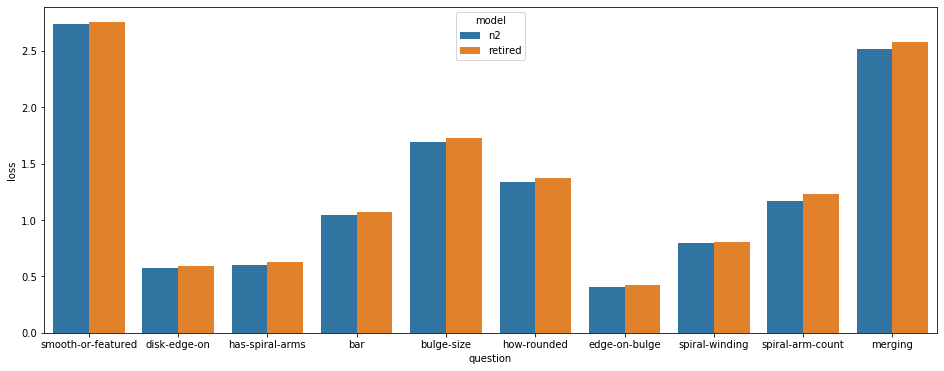

In [102]:
plt.subplots(figsize=(16, 6))
sns.barplot(data=df, x='question', y='loss', hue='model')

In [103]:
mean_per_q = df.groupby('question').agg({'loss': 'min'}).reset_index()
mean_per_q['min_loss'] = mean_per_q['loss']
del mean_per_q['loss']

In [104]:
df = pd.merge(df, mean_per_q, on='question', how='inner')

In [105]:
df['loss_delta'] = df['loss'] - df['min_loss']

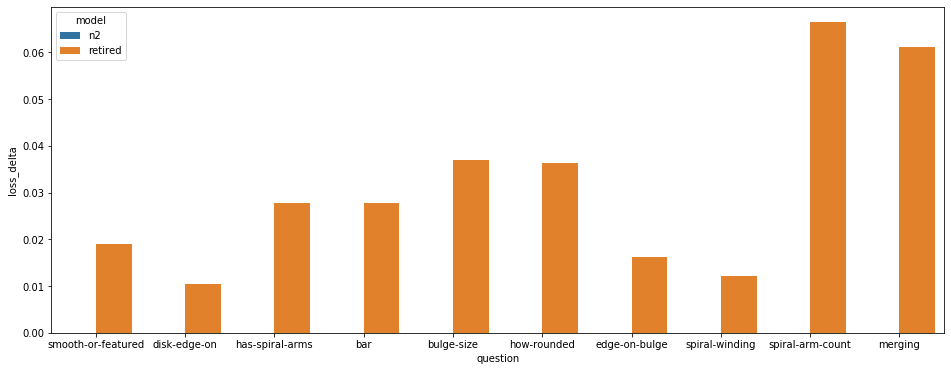

In [106]:
plt.subplots(figsize=(16, 6))
sns.barplot(data=df, x='question', y='loss_delta', hue='model')